In [1]:
%matplotlib notebook
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

from scipy.stats.stats import pearsonr
from scipy import signal
from ipyparallel import Client
from ipyparallel import depend, require, dependent
from roipoly import roipoly
from scipy.ndimage import gaussian_filter
from sklearn.externals.joblib import Parallel, delayed, cpu_count
from sklearn.utils import gen_even_slices
import cv2
#Shape of the data
height = 256
width = 256

B_USE_RED_CHANNEL = False

#28.815 and 86.5576
#90.14531424656546
TRUE_FRAMERATE = 28.815
BEHAVIOUR_FRAMERATE = 1/(11090.9/1e6)

In [177]:
# make folders
import os
directory = "/media/gu4n1n3/Data3/2_mice/20180427/"
#directory = "/media/gu4n1n3/Data2/ObjRecog/20171030/"
os.chdir(directory)
for i in range(0, 4):
    os.mkdir("Experiment_%s" %(str(i+1)))
    os.chdir("Experiment_%s" %(str(i+1)))
    os.mkdir("Behaviour")
    os.mkdir("Maps")
    os.chdir("..")

In [179]:
from os.path import join, getsize
import os
directory = "/media/gu4n1n3/Data3/2_mice/20180316/"
#direcotyr = "/media/gu4n1n3/Data2/ObjRecog/20171030/"
for root, dirs, files in os.walk(directory):
    if not "Experiment" in root:
        for file in files:
            for i in range(13):
                if ("experiment-%s_" % (str(i+1))) in file:
                    #os.rename(directory+file, directory+"Experiment_%s/"%(str(i+1))+file )
                    os.rename(directory+file, directory+"Experiment_%s/Behaviour/"%(str(i+1))+file )

In [177]:
# AUTOMATIC EXPERIMENT SELECTOR
directory = "/media/gu4n1n3/Data3/2_mice/20180420/"
experiment = "Experiment_3/"

import os
from os.path import join, getsize
all_files = None
for root, dirs, files in os.walk(directory+experiment):
    if not "Behaviour" in root and "Maps" not in root:
        all_files = files

print(all_files)
left_mouse = None
right_mouse = None
prev_video_file = None
prev_timestamps_file = None
left_mouse_timestamps_file = None
right_mouse_timestamps_file = None
stim_frames_file = None
for i, file in enumerate(all_files):
    if ".raw" in file and "combined" not in file and 'mask' not in file and 'special' not in file and 'mean' not in file \
       and 'processed' not in file and "testing" not in file and "lmao" not in file and ".mp4" not in file and 'gsr' not in file:
        if "timestamps" in file:
            
            if prev_timestamps_file == None:
                prev_timestamps_file = file
            else:
                if file.index("L") < prev_timestamps_file.index("L"):
                    left_mouse_timestamps_file = directory+experiment+file
                    right_mouse_timestamps_file = directory+experiment+prev_timestamps_file
                else:
                    left_mouse_timestamps_file = directory+experiment+prev_timestamps_file
                    right_mouse_timestamps_file = directory+experiment+file
        else:
            if prev_video_file == None:
                prev_video_file = file
            else:
                if file.index("L") < prev_video_file.index("L"):
                    left_mouse = directory+experiment+file
                    right_mouse = directory+experiment+prev_video_file
                else:
                    left_mouse = directory+experiment+prev_video_file
                    right_mouse = directory+experiment+file
    elif ".txt" in file:
        stim_frames_file = directory+experiment+file


#right_mouse = left_mouse
print(left_mouse)
print(right_mouse)
print(left_mouse_timestamps_file)
print(right_mouse_timestamps_file)
print(stim_frames_file)
assert left_mouse != None
assert right_mouse != None
assert left_mouse_timestamps_file != None
assert right_mouse_timestamps_file != None

['MM804L_April-20_1332_experiment-3_M902R_wt_non-cage-mates_first_meet_together_12mm_dff0_bandpass0.01-12.0Hz_.npy', 'LM_mask.npy', 'RM_mask_256.npy', 'LEFT_BLUE_processed__dff0_bandpass0.01-12.0Hz_MM804L_April-20_1332_experiment-3_M902R_wt_non-cage-mates_first_meet_together_12mm.raw', 'RIGHT_GREEN_processed__dff0_bandpass0.01-12.0Hz_MM902R_April-20_1329_experiment-3_M804L_wt_non-cage-mates_first_meet_together_12mm.raw', 'MM804L_April-20_1332_experiment-3_M902R_wt_non-cage-mates_first_meet_together_12mm.raw', 'the_signals.npy', 'LEFT_GREEN_processed__dff0_bandpass0.01-12.0Hz_MM804L_April-20_1332_experiment-3_M902R_wt_non-cage-mates_first_meet_together_12mm.raw', 'RIGHT_corrected_g_by_b_processed__dff0_bandpass0.01-12.0Hz_MM902R_April-20_1329_experiment-3_M804L_wt_non-cage-mates_first_meet_together_12mm.raw', 'frequency_split_correlation_filtered_ws=3800.py.npy', 'LEFT_corrected_g_by_b_processed__dff0_bandpass0.01-12.0Hz_MM804L_April-20_1332_experiment-3_M902R_wt_non-cage-mates_first_me

In [3]:
class Position:
    """postion by row, col 
    """
    def __init__(self, row, col):
        self.row = row
        self.col = col

class Seed:
    # in mm
    """
    name of seed
    y,x position of seed in mm
    """
    def __init__(self, name, y, x):
        self.name = name
        self.y = y
        self.x = x
        
class ScaledSeed(Seed):
    """Overwrites Seed init
    """
    def __init__(self, name, row, col, bregma):
        self.name = name
        self.row = row
        self.col = col
        self.signal = None
        self.bregma = bregma
        self.corr_map = None

# Load the frames
def get_raw_frames(filename, channel):
    """extract channel from video file
    : return np.ndarray
    """
    with open(filename, "rb") as file:
        raw_frames = np.fromfile(file, dtype=np.uint8)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height*3)), height, width, 3))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :, channel]
    
def get_dark_frames(green_frames):
    """for first and last 1000 frames, find index of dark frames by comparing mean to a threshold
    """
    threshold = 4
    green_frames = np.reshape(green_frames, (green_frames.shape[0], green_frames.shape[1]*green_frames.shape[2]))
    temporal_means = np.mean(green_frames, axis=1)
    start_index = 0
    end_index = 0
    for mean, i in zip(temporal_means, range(0, temporal_means.shape[0]-1)):
        if mean < threshold and i < 1000:
            start_index= i
        elif mean < threshold and i >= 1000:
            end_index = i
            break

            
    return (start_index, end_index)

def rotate_video(frames, k):
    """rotate frames by 90 degrees
    """
    for i in range(len(frames)):
        frames[i] = np.rot90(frames[i], k)
        
    return frames

# list of Seed objects
old_seeds = [Seed("V1", -3, 2.5), Seed("OB", 4.4, .86), Seed("XX", -1.75, 3.5), 
             Seed("BC", -1, 3.5), Seed("HL", -.25, 2), Seed("FL", .25, 2), 
             Seed("M1", 1.75, 1.5), Seed("RS", -2.5, 1), Seed("AC", 0, 1), 
             Seed("M2", 2.75, 1.25), Seed("OR", .75, 3)]

# An array/list where bregma[0] is y and bregma[1] is x
# Gives you back a list of seeds, as per matthieu vanni matlab program.
#ppmm is pixels per mm. 256/10mm or so for hyperscanner :/
# Direction is one of 'u', 'd', 'l', 'r' Indicates the direction mouse is facing.
#Seed("V1", -3.2678, 2.5168)
def generate_seeds(bregma, ppmm, direction=None):
    """generate scaled seeds
    !!! where is bregma classdef
    """
    # All the seeds
    #Seed("OB", 4.6, .86)
    seeds = [Seed("M1", 1.03+1, 1.365), 
             Seed("FL", .16, 2.47), Seed("HL", -.7, 1.85), Seed("aBC", -1.36+.575, 3.35), 
             Seed("pBC", -1.9, 3.35), Seed("AC", 0+1, 0.6),  Seed("RS", -2.8858+1, 0.62043),
             Seed("V1", -4.2678+.8, 2.5168), Seed("mPTA", -2.4962, 2.2932), Seed("lPTA", -2.4962-0.3, 3.35-0.2), Seed("Un", -1.5, 2.6)]    
    
    ppmmed_seeds = []
    if direction == 'u' or direction == None:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
    elif direction == 'd':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
    elif direction == 'r':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.col-ppmm*seed.x), int(bregma.row+ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.col+ppmm*seed.x), int(bregma.row+ppmm*seed.y), bregma))
    else:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.col+ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.col-ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
    return ppmmed_seeds
            
    

In [1]:
# Video processing
#rc = Client()
#lview = rc.load_balanced_view()
def calculate_df_f0(frames):
    """fractional change in intensity for each pixel
    : return df/f0 with nans very black
    : return variance of df/d0
    """
    frames = frames.astype(np.float32)
    baseline = np.mean(frames, axis=0)
    frames = np.divide(np.subtract(frames, baseline), baseline)
    
    # Make the nans very black.
    frames[np.where(np.isnan(frames))] = -1
    
    return frames, np.var(frames, axis=0)

def correct_channel_a_by_b(a, b):
    """page9 bottom"""
    return (a)/(1+b)

# @lview.parallel()
# @require('scipy.signal')
# def filter_pixel(pixel):
#     low_limit = 0.1
#     high_limit = 3.0
#     frame_rate = 28.815
#     nyq = frame_rate/2.0
#     low_limit = low_limit/nyq
#     high_limit = high_limit/nyq
#     order = 4
#     rp = 0.1
#     Wn = [low_limit, high_limit]
    
#     b, a = signal.cheby1(order, rp, Wn, 'bandpass', analog=False)
#     return signal.filtfilt(b, a, pixel)


# FRAMES HAS SHAPE:
# numpy array float32(frames, width, height)
# limit is the low freq cuttoff
# frame rate is... frame-rate rofl.
def highpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("HIGHPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'highpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames

def lowpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("LOWPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'lowpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames  
    
def highpass_filter(frames, limit, frame_rate):
    """duplicate
    """
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("HIGHPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'highpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames

def cheby_filter(frames, low_limit, high_limit, frame_rate):
    """Bandpass filter,, uses filtfilt
    """
    nyq = frame_rate/2.0
    low_limit = low_limit/nyq
    high_limit = high_limit/nyq
    order = 4
    rp = 0.1
    Wn = [low_limit, high_limit]
    
    b, a = signal.cheby1(order, rp, Wn, 'bandpass', analog=False)
    print("Filtering...")

    #frames = frames.reshape(frames.shape[0], frames.shape[1]*frames.shape[2])
    #parallel_result = filter_pixel.map(frames[:])
    #parallel_result= np.asarray(parallel_result).reshape((frames.shape[0], height, width))
    frames = signal.filtfilt(b, a, frames, axis=0)
    #print("Shape!", parallel_result.shape)
    print("Done!")
    return frames

def calculate_correlation_map_of_slice(slice_frames, seed):
    """pearson correlation by seed
    !!! where is correlation defined?
    """
    slice_map = np.zeros((slice_frames.shape[1]))
    for i in range(slice_frames.shape[1]):
        slice_map[i] = correlation(slice_frames[:, i], seed)

    return slice_map


def cheby1_bandpass(low_limit, high_limit, frame_rate, order=4, rp=0.1):
    """bandpass, 
    uses cheby1
    """
    nyq = frame_rate*0.5
    low_limit = low_limit/nyq
    high_limit = high_limit/nyq
    Wn=[low_limit, high_limit]
    
    b, a = signal.cheby1(order, rp, Wn, btype='bandpass', analog=False)
    return b, a

def cheby1_bandpass_filter(data, b, a):
    """bandpass with lfilter"""
    y = signal.lfilter(b, a, data, axis=0)
    return y

def cheby1_filter_parallel(FRAMES, low_limit, high_limit, frame_rate, order=5, rp=0.1, n_jobs=-1):
    """use ipython parallel to map sklearn.gen_even_slices
    """
    
    height = FRAMES.shape[1]
    width = FRAMES.shape[2]
    n_frames = FRAMES.shape[0]
    FRAMES = FRAMES.reshape(FRAMES.shape[0], FRAMES.shape[1]*FRAMES.shape[2])
    print(np.shape(FRAMES))
    b, a = cheby1_bandpass(low_limit, high_limit, frame_rate, order, rp)
    
    if n_jobs < 0:
        n_jobs = max(cpu_count() + 1 + n_jobs, 1)
        
    fd = delayed(cheby1_bandpass_filter)
    ret = Parallel(n_jobs=n_jobs, verbose=0)(
        fd(FRAMES[:, s], b, a)
        for s in gen_even_slices(FRAMES.shape[1], n_jobs))
        
    return np.hstack(ret).reshape(n_frames, height, width)

def gsr(frames, mask):
    """Global signal regression(fig3?)
    """
    mask=mask==255 # logical maksing
    mask=np.reshape(mask,mask.shape[0]*mask.shape[1])
    indices = np.where((mask == True))
    indices=np.asarray(indices)
    
    brain_frames = np.zeros((frames.shape[0], indices.shape[1]))

    frames = np.reshape(frames, (frames.shape[0], frames.shape[1]*frames.shape[2]))
    brain_frames[:, :] = np.squeeze(frames[:, indices])
    #for i in range(frames.shape[0]):
    #    brain_frames[i, :] = frames[i, indices]



    mean_g = np.mean(brain_frames, axis=1)
    g_plus = np.squeeze(np.linalg.pinv([mean_g]))

    beta_g = np.dot(g_plus, frames)
    
    print(np.shape(mean_g))
    print(np.shape(beta_g))
    global_signal = np.dot(np.asarray([mean_g]).T, [beta_g])
    frames = frames - global_signal
    frames = np.reshape(frames, (frames.shape[0], width, height))
    return frames,mean_g


In [5]:

#right_mouse = None# Interpolation of missed frames

def open_raw_timestamps(filename):
    with open(filename, 'rb') as file:
        raw_timestamps = np.fromfile(file, dtype=np.float32)
        raw_timestamps[0] = 1
        return raw_timestamps[np.where(raw_timestamps > 0)]
    
    
def get_locations_of_dropped_frames(timestamps):
    differences = np.diff(timestamps,1)
    #print(differences[:100])
    print("Mean filtered frame difference: ", np.mean(differences[np.where(differences<=50000)]))
    #50,000 for 30fps
    #12,500 for 90fps
    return differences, np.where(differences>50000)


class Pair:
    def __init__(self, pair_frames, number_of_dropped_frames, location):
        self.pair_frames = pair_frames
        self.number_of_dropped_frames = number_of_dropped_frames
        #location the frames need to be added
        self.location = location
        # Must eventually make it to use all channels.
        self.interpolated = np.empty((self.number_of_dropped_frames+2, height, width), dtype=np.uint8)
        
        
# t_pts is a list of the places where frames were dropped.
# diffs is a list of all the differences from one frame to the next.
# so you get how many frames were dropped by polling the locations at which
# frames were dropped and looking at how large the difference is.
def generate_pairs(frames, t_pts, diffs):
    list_of_pairs = []
    for timepoint in t_pts[0]:
        number_of_dropped_frames = int(np.round(diffs[timepoint]/(1.e6/TRUE_FRAMERATE)))-1
        pair_frames = frames[timepoint:timepoint+2]
        list_of_pairs.append(Pair(pair_frames, number_of_dropped_frames, timepoint))
        
        
    return list_of_pairs
        
    
def pairs_to_interp(pairs):
    total_frames_dropped = 0
    for pair in pairs:
        total_frames_dropped += pair.number_of_dropped_frames
        for i in range(np.shape(pair.pair_frames)[1]):
            for j in range(np.shape(pair.pair_frames)[2]):
                x = np.linspace(0, pair.number_of_dropped_frames+1, 2)
                x_interp = np.linspace(0, pair.number_of_dropped_frames+1, pair.number_of_dropped_frames+2)
                y_interp = np.interp(x_interp, x, pair.pair_frames[:, i, j])
                pair.interpolated[: , i, j] = y_interp
                
                #Testing to make sure what we get makes sense.
                assert np.shape(pair.interpolated)[0] == np.size(y_interp)
                assert pair.interpolated[0, i, j] == pair.pair_frames[0, i, j]
                assert pair.interpolated[-1, i, j] == pair.pair_frames[-1, i, j] 
                
                
                
    print("Total Frames Dropped: ", total_frames_dropped)

                    
def insert_interpolated_frames_to_video(green_frames, pairs):
    shifting_index = 0
    for pair in pairs:
        old_number_frames = green_frames.shape[0]
        assert np.array_equal(green_frames[pair.location+shifting_index, :, :], pair.interpolated[0, :, :])
        assert np.array_equal(green_frames[pair.location+shifting_index+1, :, :], pair.interpolated[-1, :, :])
        green_frames = np.insert(green_frames, pair.location+shifting_index+1, pair.interpolated[1:-1, :, :], 0)
        assert green_frames.shape[0] == pair.number_of_dropped_frames + old_number_frames
        
        print("Inserted", pair.number_of_dropped_frames, " frames at frame index", pair.location+shifting_index)
        shifting_index += pair.number_of_dropped_frames
        
        
        
    return green_frames


def get_behaviour_frames(video_file, height, width):
    cap = cv2.VideoCapture(video_file)
    counter = 0
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        counter += 1
    cap.release()

    
    frames = np.zeros((counter, height, width), dtype=np.uint8)
    print(frames.shape)
    cap = cv2.VideoCapture(video_file)
    counter = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #frames[counter, :, :] = gray
        frames[counter, :, :] = color[:, :, 0]
        counter += 1
    cap.release()
    
    
    return frames


def get_raw_behaviour_frames(video_file, height, width, dtype=np.uint8):
    with open(video_file, "rb") as file:
        raw_frames = np.fromfile(file, dtype=dtype)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :]

def get_processed_frames(filename, height, width):
    with open(filename, 'rb') as file:
        raw_frames = np.fromfile(file, dtype=np.float32)
        #raw_frames = raw_frames.byteswap(True)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height)), height, width))
        print(np.shape(raw_frames))
        
    return raw_frames


def get_dark_frames_gradient_method(behaviour_frames, sigma=15, show_plot=False, spacetime=False):
    
    ## convolution nusing gaussian sigma 20 (why 15?)
    if spacetime:
        means = np.mean(behaviour_frames, axis=1)
    else:
        means = np.mean(np.mean(behaviour_frames, axis=1), axis=1)
    grad = np.gradient(means)
    mean = np.mean(grad)
    std = np.std(grad)
    
    if show_plot:
        plt.figure()
        plt.plot(np.gradient(means))
        plt.show()

    indeces = grad[np.where(np.abs(grad)>mean+std*sigma)]
    start = np.where(grad==indeces[0])
    stop = np.where(grad==indeces[-1])
    assert (len(start)==1)
    assert (len(stop)==1)
    return (start[0][0], stop[0][0])

<IPython.core.display.Javascript object>


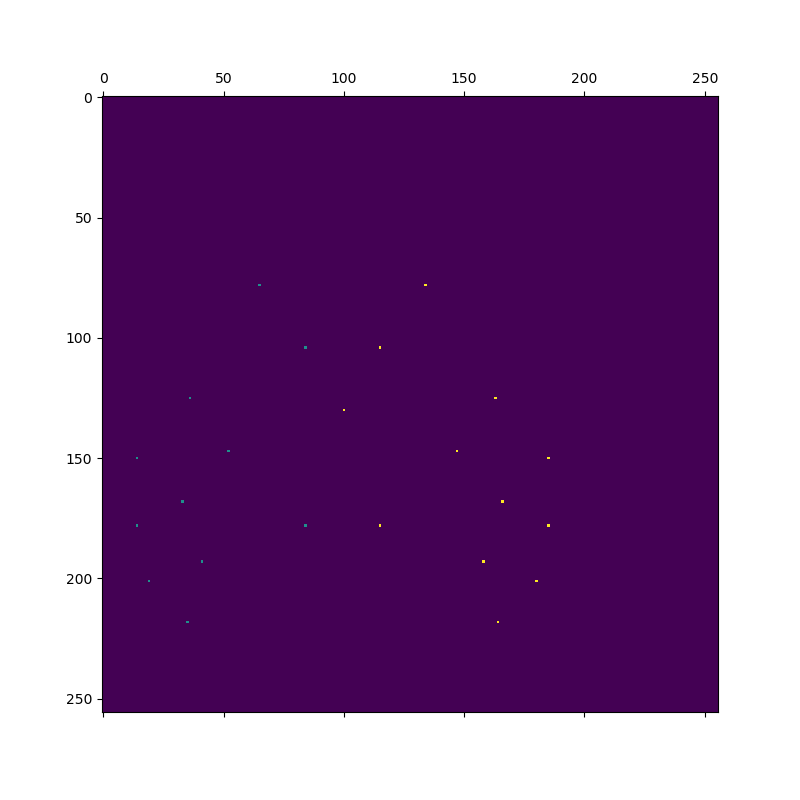

lmao


In [6]:
# Test seed plots
image = np.zeros((256, 256), dtype=np.uint8)

br = Position(130, 100)
seeds = generate_seeds(br, 25.6, 'u')

normal_seeds_x_R = []
normal_seeds_y_R = []
normal_seeds_x_L = []
normal_seeds_y_L = []
image[br.row, br.col] = 255
for seed in seeds:
    if "-R" in seed.name:
        image[seed.row, seed.col] = 255
        normal_seeds_x_R.append(seed.col)
        normal_seeds_y_R.append(seed.row)
    else:
        image[seed.row, seed.col] = 128
        normal_seeds_x_L.append(seed.col)
        normal_seeds_y_L.append(seed.row)
    
seeds_fig = plt.figure(figsize=(8, 8))
seeds_ax = seeds_fig.add_subplot(111)
seeds_ax.matshow(image)
# seeds_ax.plot(br.col, br.row, '.k')
# seeds_ax.plot(normal_seeds_x_L, normal_seeds_y_L, '.b')
# seeds_ax.plot(normal_seeds_x_R, normal_seeds_y_R, '.r')
plt.savefig("/home/gu4n1n3/Desktop/seeds.svg")
plt.show()
print("lmao")


In [178]:
# Import two mice!
# Also interpolate any missing frames.
#Shape of the data
height = 256
width = 256

processing = "_"

print("Importing video files...",)
left_mouse_green_frames = get_raw_frames(left_mouse, 1)
right_mouse_green_frames = get_raw_frames(right_mouse, 1)
left_mouse_blue_frames = get_raw_frames(left_mouse, 2)
right_mouse_blue_frames = get_raw_frames(right_mouse, 2)
if B_USE_RED_CHANNEL:
    left_mouse_red_frames = get_raw_frames(left_mouse, 0)
    right_mouse_red_frames = get_raw_frames(right_mouse, 0)
title = left_mouse.split('/')[-1]
title = title.split('.')[0]
print("[DONE]")

#Save a single left and right frame of mouse
np.save(directory+experiment+"LEFT_RAW_GREEN_FRAME.npy", left_mouse_green_frames[left_mouse_green_frames.shape[0]//2, :, :])
np.save(directory+experiment+"RIGHT_RAW_GREEN_FRAME.npy", right_mouse_green_frames[right_mouse_green_frames.shape[0]//2, :, :])

np.save(directory+experiment+"LEFT_RAW_BLUE_FRAME.npy", left_mouse_blue_frames[left_mouse_blue_frames.shape[0]//2, :, :])
np.save(directory+experiment+"RIGHT_RAW_BLUE_FRAME.npy", right_mouse_blue_frames[right_mouse_blue_frames.shape[0]//2, :, :])


print("Importing timestamps...",)
left_timestamps = open_raw_timestamps(left_mouse_timestamps_file)
right_timestamps = open_raw_timestamps(right_mouse_timestamps_file)
print("[DONE]")

print("Calculating differences and the framedrop timepoints...",)
left_differences, left_frame_drop_timepoints = get_locations_of_dropped_frames(left_timestamps)
right_differences, right_frame_drop_timepoints = get_locations_of_dropped_frames(right_timestamps)
print("[DONE]")

print("Difference between acquire times:", left_timestamps[-1]-right_timestamps[-1])

print("Generating pairs of frames where between the two are the missing frames...",)
left_pairs = generate_pairs(left_mouse_green_frames, left_frame_drop_timepoints, left_differences)
right_pairs = generate_pairs(right_mouse_green_frames, right_frame_drop_timepoints, right_differences)

left_blue_pairs = generate_pairs(left_mouse_blue_frames, left_frame_drop_timepoints, left_differences)
right_blue_pairs = generate_pairs(right_mouse_blue_frames, right_frame_drop_timepoints, right_differences)

if B_USE_RED_CHANNEL:
    left_red_pairs = generate_pairs(left_mouse_red_frames, left_frame_drop_timepoints, left_differences)
    right_red_pairs = generate_pairs(right_mouse_red_frames, right_frame_drop_timepoints, right_differences)
print("[DONE]")

print("Interpolating the data...",)
if len(left_pairs) > 0 and  len(right_pairs) > 0:
    processing += "interp_"
pairs_to_interp(left_pairs)
pairs_to_interp(right_pairs)

pairs_to_interp(left_blue_pairs)
pairs_to_interp(right_blue_pairs)

if B_USE_RED_CHANNEL:
    pairs_to_interp(left_red_pairs)
    pairs_to_interp(right_red_pairs)
print("[DONE]")

print("Inserting new frames into the raw data...",)
left_mouse_green_frames = insert_interpolated_frames_to_video(left_mouse_green_frames, left_pairs).astype(np.float32)
right_mouse_green_frames = insert_interpolated_frames_to_video(right_mouse_green_frames, right_pairs).astype(np.float32)

left_mouse_blue_frames = insert_interpolated_frames_to_video(left_mouse_blue_frames, left_blue_pairs).astype(np.float32)
right_mouse_blue_frames = insert_interpolated_frames_to_video(right_mouse_blue_frames, right_blue_pairs).astype(np.float32)

if B_USE_RED_CHANNEL:
    left_mouse_red_frames = insert_interpolated_frames_to_video(left_mouse_red_frames, left_red_pairs)
    right_mouse_red_frames = insert_interpolated_frames_to_video(right_mouse_red_frames, right_red_pairs)
print("[DONE]")

print("Removing dark frames!")
# lag = -8
# processing += "%s_FramesLag_" % (str(lag))
start, stop = get_dark_frames(left_mouse_green_frames)
left_start_frame = start
left_mouse_green_frames = left_mouse_green_frames[start+2:stop-1, :, :]
left_mouse_blue_frames = left_mouse_blue_frames[start+2:stop-1, :, :]
if B_USE_RED_CHANNEL:
    left_mouse_red_frames = left_mouse_red_frames[start+2:stop-1, :, :]

start, stop = get_dark_frames(right_mouse_green_frames)
right_start_frame = start
right_mouse_green_frames = right_mouse_green_frames[start+2:stop-1, :, :]
right_mouse_blue_frames = right_mouse_blue_frames[start+2:stop-1, :, :]
if B_USE_RED_CHANNEL:
    right_mouse_red_frames = right_mouse_red_frames[start+2:stop-1, :, :]


print(left_mouse_green_frames.shape)
print(right_mouse_green_frames.shape)

#Rotate them
#left_mouse_green_frames = rotate_video(left_mouse_green_frames, -1)
#right_mouse_blue_frames = rotate_video(right_mouse_blue_frames, 1)

#left_mouse_blue_frames = rotate_video(left_mouse_blue_frames, -1)
#right_mouse_green_frames = rotate_video(right_mouse_green_frames, 1)


orig_left_first_green_frame = np.copy(left_mouse_green_frames[0, :, :])
orig_right_first_green_frame = np.copy(right_mouse_green_frames[0, :, :])

orig_left_first_blue_frame = np.copy(left_mouse_blue_frames[0, :, :])
orig_right_first_blue_frame = np.copy(right_mouse_blue_frames[0, :, :])


left_var_green_frames = np.var(left_mouse_green_frames, axis=0)
right_var_green_frames = np.var(right_mouse_green_frames, axis=0)

left_mean_green_frames = np.mean(left_mouse_green_frames, axis=0)
right_mean_green_frames = np.mean(right_mouse_green_frames, axis=0)

processing += "dff0_"
left_mouse_green_frames, left_var_green_frames = calculate_df_f0(left_mouse_green_frames)
right_mouse_green_frames, left_var_green_frames = calculate_df_f0(right_mouse_green_frames)

left_mouse_blue_frames, left_var_blue_frames = calculate_df_f0(left_mouse_blue_frames)
right_mouse_blue_frames, right_var_blue_frames = calculate_df_f0(right_mouse_blue_frames)

if B_USE_RED_CHANNEL:
    left_mouse_red_frames, left_var_red_frames = calculate_df_f0(left_mouse_red_frames)
    right_mouse_red_frames, right_var_red_frames = calculate_df_f0(right_mouse_red_frames)
#processing += "blue_correction_"
#left_mouse_green_frames = correct_green(left_mouse_green_frames, left_mouse_blue_frames)
#right_mouse_green_frames = correct_green(right_mouse_green_frames, right_mouse_blue_frames)

low_limit = 0.01
high_limit = 12.0
processing += "bandpass0.01-3.0Hz_"
print("Filtering green")
left_mouse_green_frames = cheby1_filter_parallel(left_mouse_green_frames, low_limit, high_limit, TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
right_mouse_green_frames = cheby1_filter_parallel(right_mouse_green_frames, low_limit, high_limit, TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
print("Filtering blue")
left_mouse_blue_frames = cheby1_filter_parallel(left_mouse_blue_frames, low_limit, high_limit, TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
right_mouse_blue_frames = cheby1_filter_parallel(right_mouse_blue_frames, low_limit, high_limit, TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
if B_USE_RED_CHANNEL:
    print("Filtering red")
    left_mouse_red_frames = cheby1_filter_parallel(left_mouse_red_frames, low_limit, high_limit, TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
    right_mouse_red_frames = cheby1_filter_parallel(right_mouse_red_frames, low_limit, high_limit, TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
#left_mouse_green_frames = lowpass_filter(left_mouse_green_frames, 4, TRUE_FRAMERATE)
#right_mouse_green_frames = lowpass_filter(right_mouse_green_frames, 4, TRUE_FRAMERATE)
#left_mouse_green_frames = left_mouse_green_frames[500:, :, :]
#right_mouse_green_frames = right_mouse_green_frames[500:, :, :]

#Generate seeds
# generate_seeds(bregma, ppmm, direction=None):
#left_seeds = generate_seeds(left_bregma, left_ppmm, direction='r')
#right_seeds = generate_seeds(right_bregma, right_bregma, direction='l')

#matrix = generate_matrix_two_mice(left_mouse_green_frames, right_mouse_green_frames, left_seeds, right_seeds)


print("done")

Importing video files...
(10373, 256, 256, 3)
(10369, 256, 256, 3)
(10373, 256, 256, 3)
(10369, 256, 256, 3)
[DONE]
Importing timestamps...
[DONE]
Calculating differences and the framedrop timepoints...
Mean filtered frame difference:  34703.83
Mean filtered frame difference:  34704.0
[DONE]
Difference between acquire times: -1824.0
Generating pairs of frames where between the two are the missing frames...
[DONE]
Interpolating the data...
Total Frames Dropped:  0
Total Frames Dropped:  4
Total Frames Dropped:  0
Total Frames Dropped:  4
[DONE]
Inserting new frames into the raw data...
Inserted 1  frames at frame index 866
Inserted 2  frames at frame index 3609
Inserted 1  frames at frame index 4186
Inserted 1  frames at frame index 866
Inserted 2  frames at frame index 3609
Inserted 1  frames at frame index 4186
[DONE]
Removing dark frames!
(10083, 256, 256)
(10084, 256, 256)


/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


Filtering green
(10083, 65536)
(10084, 65536)
Filtering blue
(10083, 65536)
(10084, 65536)
done


In [179]:
if left_mouse_green_frames.shape[0] != right_mouse_green_frames.shape[0]:
    if left_mouse_green_frames.shape[0] < right_mouse_green_frames.shape[0]:
        right_mouse_green_frames = right_mouse_green_frames[:left_mouse_green_frames.shape[0]]
        right_mouse_blue_frames = right_mouse_blue_frames[:left_mouse_blue_frames.shape[0]]
    elif right_mouse_green_frames.shape[0] < left_mouse_green_frames.shape[0]:
        left_mouse_green_frames = left_mouse_green_frames[:right_mouse_green_frames.shape[0]]
        left_mouse_blue_frames = left_mouse_blue_frames[:right_mouse_blue_frames.shape[0]]
        
assert left_mouse_green_frames.shape[0] == right_mouse_green_frames.shape[0]

In [180]:
# Save the processed left and right separately
print("Saving Left Mouse")
left_mouse_green_frames = left_mouse_green_frames.astype(np.float32)
left_mouse_blue_frames = left_mouse_blue_frames.astype(np.float32)
if B_USE_RED_CHANNEL:
    left_mouse_red_frames = left_mouse_red_frames.astype(np.float32)
left_mouse_green_frames.tofile(directory+experiment+"LEFT_GREEN_processed_"+processing+left_mouse.split('/')[-1].split('.')[0]+".raw")
left_mouse_blue_frames.tofile(directory+experiment+"LEFT_BLUE_processed_"+processing+left_mouse.split('/')[-1].split('.')[0]+".raw")
if B_USE_RED_CHANNEL:
    left_mouse_red_frames.tofile(directory+experiment+"LEFT_RED_processed_"+processing+left_mouse.split('/')[-1].split('.')[0]+".raw")

print("Done!")

Saving Left Mouse
Done!


In [181]:
# Save the processed left and right separately
print("Saving Right Mouse")
right_mouse_green_frames = right_mouse_green_frames.astype(np.float32)
right_mouse_blue_frames = right_mouse_blue_frames.astype(np.float32)
if B_USE_RED_CHANNEL:
    right_mouse_red_frames = right_mouse_red_frames.astype(np.float32)
right_mouse_green_frames.tofile(directory+experiment+"RIGHT_GREEN_processed_"+processing+right_mouse.split('/')[-1].split('.')[0]+".raw")
right_mouse_blue_frames.tofile(directory+experiment+"RIGHT_BLUE_processed_"+processing+right_mouse.split('/')[-1].split('.')[0]+".raw")
if B_USE_RED_CHANNEL:
    right_mouse_red_frames.tofile(directory+experiment+"RIGHT_RED_processed_"+processing+right_mouse.split('/')[-1].split('.')[0]+".raw")

print("Done!")

Saving Right Mouse
Done!


In [ ]:
#Save em.|
print("Sa2ving!")
combined = np.concatenate((left_mouse_green_frames, right_mouse_green_frames), axis=2)
combined = combined.astype(np.float32)
combined.tofile(directory+experiment+"combined"+processing+".raw")
print("done")

# Correct the green channel by red and blue

In [162]:
corrected_left_mouse_green_by_blue_frames = correct_channel_a_by_b(left_mouse_green_frames, left_mouse_blue_frames)
if B_USE_RED_CHANNEL:
    corrected_left_mouse_green_by_red_frames = correct_channel_a_by_b(left_mouse_green_frames, left_mouse_red_frames)

corrected_right_mouse_green_by_blue_frames = correct_channel_a_by_b(right_mouse_green_frames, right_mouse_blue_frames)
if B_USE_RED_CHANNEL:
    corrected_right_mouse_green_by_red_frames = correct_channel_a_by_b(right_mouse_green_frames, right_mouse_red_frames)

/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide


In [163]:
#Save Corrected
print("Saving Corrected Movies")
corrected_left_mouse_green_by_blue_frames.tofile(directory+experiment+"LEFT_corrected_g_by_b_processed_"+processing+left_mouse.split('/')[-1].split('.')[0]+".raw")
if B_USE_RED_CHANNEL:
    corrected_left_mouse_green_by_red_frames.tofile(directory+experiment+"LEFT_correced_g_by_r_processed_"+processing+left_mouse.split('/')[-1].split('.')[0]+".raw")

corrected_right_mouse_green_by_blue_frames.tofile(directory+experiment+"RIGHT_corrected_g_by_b_processed_"+processing+right_mouse.split('/')[-1].split('.')[0]+".raw")
if B_USE_RED_CHANNEL:
    corrected_right_mouse_green_by_red_frames.tofile(directory+experiment+"RIGHT_corrected_g_by_r_processed_"+processing+right_mouse.split('/')[-1].split('.')[0]+".raw")

print("Done!")

Saving Corrected Movies
Done!


# Save a video of all the processed signals

In [ ]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='10Hz_playback')
writer = FFMpegWriter(fps=30, metadata=metadata)
fig = plt.figure(figsize=(20, 10))
fig.suptitle("The Signals for:\n"+left_mouse+"\n"+processing+"\n")

lax1 = fig.add_subplot(2, 5, 1)
lax1.set_title("Red")
lax1.get_yaxis().set_visible(False)
lax1.get_xaxis().set_visible(False)
lim_red = lax1.imshow(left_mouse_red_frames[0], cmap='viridis', vmin=-0.2, vmax=0.2)
cbar1 = fig.colorbar(lim_red)

lax2 = fig.add_subplot(2, 5, 2)
lax2.set_title("Green")
lax2.get_yaxis().set_visible(False)
lax2.get_xaxis().set_visible(False)
lim_green = lax2.imshow(left_mouse_green_frames[0], cmap='viridis', vmin=-0.05, vmax=0.2)
cbar2 = fig.colorbar(lim_green)

lax3 = fig.add_subplot(2, 5, 3)
lax3.set_title("Blue")
lax3.get_yaxis().set_visible(False)
lax3.get_xaxis().set_visible(False)
lim_blue = lax3.imshow(left_mouse_blue_frames[0], cmap='viridis', vmin=-0.02, vmax=0.05)
cbar3 = fig.colorbar(lim_blue)

lax4 = fig.add_subplot(2, 5, 4)
lax4.set_title(r"$\frac{Green}{Red}$")
lax4.get_yaxis().set_visible(False)
lax4.get_xaxis().set_visible(False)
lim_gr = lax4.imshow(corrected_left_mouse_green_by_red_frames[0], cmap='viridis', vmin=-0.05, vmax=0.2)
cbar4 = fig.colorbar(lim_gr)

lax5 = fig.add_subplot(2, 5, 5)
lax5.set_title(r"$\frac{Green}{Blue}$")
lax5.get_yaxis().set_visible(False)
lax5.get_xaxis().set_visible(False)
lim_gb = lax5.imshow(corrected_left_mouse_green_by_blue_frames[0], cmap='viridis', vmin=-0.05, vmax=0.2)
cbar5 = fig.colorbar(lim_gb)

rax1 = fig.add_subplot(2, 5, 6)
rax1.set_title("Red")
rax1.get_yaxis().set_visible(False)
rax1.get_xaxis().set_visible(False)
rim_red = rax1.imshow(right_mouse_red_frames[0], cmap='viridis', vmin=-0.2, vmax=0.2)
rcbar1 = fig.colorbar(rim_red)

rax2 = fig.add_subplot(2, 5, 7)
rax2.set_title("Green")
rax2.get_yaxis().set_visible(False)
rax2.get_xaxis().set_visible(False)
rim_green = rax2.imshow(right_mouse_green_frames[0], cmap='viridis', vmin=-0.05, vmax=0.2)
rcbar2 = fig.colorbar(rim_green)

rax3 = fig.add_subplot(2, 5, 8)
rax3.set_title("Blue")
rax3.get_yaxis().set_visible(False)
rax3.get_xaxis().set_visible(False)
rim_blue = rax3.imshow(right_mouse_blue_frames[0], cmap='viridis', vmin=-0.02, vmax=0.05)
rcbar3 = fig.colorbar(rim_blue)

rax4 = fig.add_subplot(2, 5, 9)
rax4.set_title(r"$\frac{Green}{Red}$")
rax4.get_yaxis().set_visible(False)
rax4.get_xaxis().set_visible(False)
rim_gr = rax4.imshow(corrected_right_mouse_green_by_red_frames[0], cmap='viridis', vmin=-0.05, vmax=0.2)
rcbar4 = fig.colorbar(rim_gr)

rax5 = fig.add_subplot(2, 5, 10)
rax5.set_title(r"$\frac{Green}{Blue}$")
rax5.get_yaxis().set_visible(False)
rax5.get_xaxis().set_visible(False)
rim_gb = rax5.imshow(corrected_right_mouse_green_by_blue_frames[0], cmap='viridis', vmin=-0.05, vmax=0.2)
cbar5 = fig.colorbar(rim_gb)







print("Writing frames...")
with writer.saving(fig, directory+experiment+left_mouse.split("/")[-1]+"_video_of_all_processed_signals_"+processing+".mp4", 100):
    for i in range(left_mouse_green_frames.shape[0]):
        # Set title
        current_time = np.round(float(i)/TRUE_FRAMERATE, 3)
        fig.suptitle("The Signals for:\n"\
                     +left_mouse+"\n"+\
                     processing+"\n"+\
                     "Current Frame: "+"{:5d}".format(i)+" Current Time: "+"{:4.3f}".format(current_time)+" seconds")
        
        lim_red.set_data(left_mouse_red_frames[i])
        lim_green.set_data(left_mouse_green_frames[i])
        lim_blue.set_data(left_mouse_blue_frames[i])
        lim_gr.set_data(corrected_left_mouse_green_by_red_frames[i])
        lim_gb.set_data(corrected_left_mouse_green_by_blue_frames[i])
        
        rim_red.set_data(right_mouse_red_frames[i])
        rim_green.set_data(right_mouse_green_frames[i])
        rim_blue.set_data(right_mouse_blue_frames[i])
        rim_gr.set_data(corrected_right_mouse_green_by_red_frames[i])
        rim_gb.set_data(corrected_right_mouse_green_by_blue_frames[i])

        #print(i//window_size)
        #print(combined_frames.shape[0]//(i*cluster_maps.shape[0])
        #int((combined_frames.shape[0]-window_size)/window_shift)+1
        writer.grab_frame()

print("Done!")

In [ ]:
plt.figure()
plt.plot(left_mouse_green_frames[:, 156, 62], color='g')
#plt.plot(left_mouse_red_frames[:, 156, 62], color='r')
plt.plot(left_mouse_blue_frames[:, 156, 62], color='b')
#plt.plot(corrected_left_mouse_green_by_blue_frames[:, 156, 62], color='c')
#plt.plot(corrected_left_mouse_green_by_red_frames[:, 156, 62], color='m')
print(pearsonr(left_mouse_green_frames[:, 156, 62], left_mouse_blue_frames[:, 156, 62]))
print(pearsonr(left_mouse_green_frames[:, 156, 62], left_mouse_red_frames[:, 156, 62]))
print(pearsonr(left_mouse_blue_frames[:, 156, 62], left_mouse_red_frames[:, 156, 62]))

# Open Behaviour Video

In [153]:
# Select file
video_file = ''
timestamps_file = ''
interpolated_file = ''
combined_file = ''
for root, dirs, files in os.walk(directory+experiment):
    if "Behaviour" in root:
        for file in files:
            if 'timestamps' in file:
                timestamps_file = os.path.join(directory, experiment, root, file)
            elif 'interpolated' in file and not 'subset' in file and 'raw' in file:
                interpolated_file = os.path.join(directory, experiment, root, file)
            elif 'h264' in file:
                video_file = os.path.join(directory, experiment, root, file)
    else:
        for file in files:
            if 'processed' in file:
                combined_file = os.path.join(directory, experiment, root, file)

print(timestamps_file)
print(video_file)
print(interpolated_file)
print(combined_file)

/media/gu4n1n3/Data2/2_mice/20180221/Experiment_6/Behaviour/M803L_MXXXR_February-21_1524_experiment-6_wt_whisker_stim_upper_timestamps.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_6/Behaviour/M803L_MXXXR_February-21_1524_experiment-6_wt_whisker_stim_upper.h264
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_6/Behaviour/M803L_MXXXR_February-21_1524_experiment-6_wt_whisker_stim_upper_interpolated.raw
/media/gu4n1n3/Data2/2_mice/20180221/Experiment_6/RIGHT_BLUE_processed__interp_dff0_bandpass0.01-12.0Hz_MMXXXR_February-21_1523_experiment-6_M804L_wt_whisker_stim_upper.raw


In [154]:
behaviour_frames = get_behaviour_frames(video_file, 180, 320)
timestamps = open_raw_timestamps(timestamps_file)
diffs, locs = get_locations_of_dropped_frames(timestamps)
behaviour_frames.tofile(directory+experiment+"Behaviour/"+"test.raw")
# Make sure no frames were dropped!
assert(len(locs[0])==0)

(32820, 180, 320)


/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


Mean filtered frame difference:  11090.9


<IPython.core.display.Javascript object>


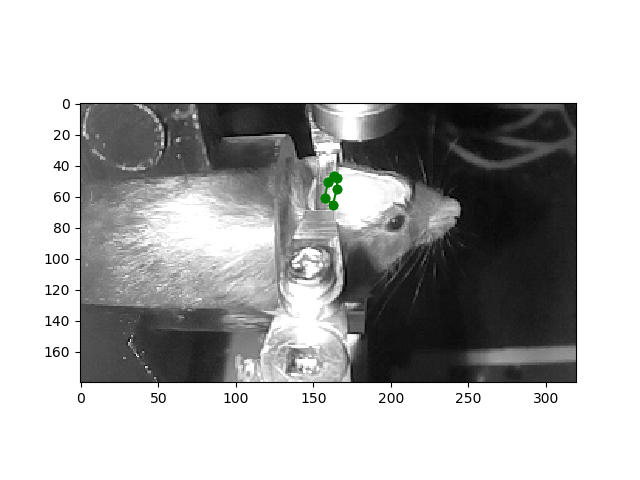

In [22]:
plt.figure()
plt.imshow(behaviour_frames[0], cmap='gray', vmin=0, vmax=255)

grad_roi = roipoly(roicolor='g')

<IPython.core.display.Javascript object>


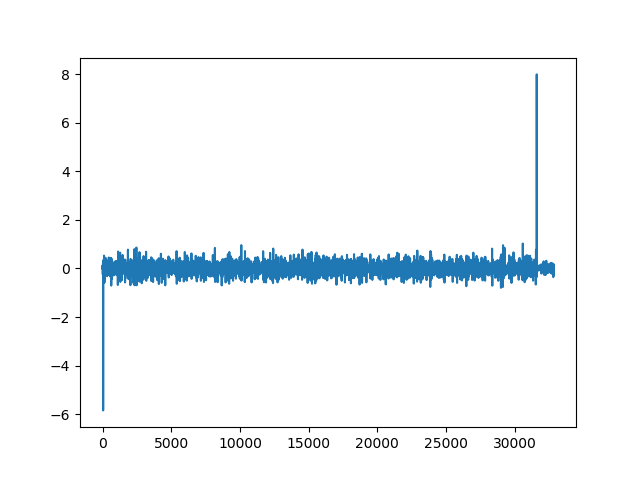

43 31603
Final Shapes
(10083, 256, 256)
(31556, 180, 320)


In [155]:
# Now find where the lights turn on and off.
#grad_mask = grad_roi.getMask(behaviour_frames[0])
#start, stop = get_dark_frames_gradient_method(behaviour_frames[:, grad_mask], show_plot=True, sigma=5, spacetime=True)
start, stop = get_dark_frames_gradient_method(behaviour_frames, show_plot=True, sigma=5)
behaviour_frames = behaviour_frames[start+3:stop-1, :, :]
print(start, stop)
print("Final Shapes")
print(np.shape(left_mouse_green_frames))
print(np.shape(behaviour_frames))

In [156]:
imaging_period = 34704.0
behaviour_period = 11090.9
#behaviour_period = 16636.4
img_total_time = imaging_period*left_mouse_green_frames.shape[0]
beh_total_time = behaviour_period*behaviour_frames.shape[0]

print("Imaging total time: ", img_total_time, left_mouse_green_frames.shape)
print("Behaviour total time: ", beh_total_time, behaviour_frames.shape)
print((beh_total_time-img_total_time))

Imaging total time:  349920432.0 (10083, 256, 256)
Behaviour total time:  349984440.4 (31556, 180, 320)
64008.39999997616


In [157]:
indeces = []
b = 0
tmp_img_time = img_total_time
tmp_beh_time = beh_total_time

if img_total_time > beh_total_time:
    while True:
        if tmp_img_time > tmp_beh_time:
            if b < behaviour_frames.shape[0]:
                indeces.append(b)
            tmp_img_time-=imaging_period
            if tmp_img_time < 0:
                break

        tmp_beh_time-= behaviour_period
        b+=1
else:
    tmp_img_time+=imaging_period
    while True:
        if tmp_img_time > tmp_beh_time:
            if b < behaviour_frames.shape[0]:
                indeces.append(b)
            tmp_img_time-=imaging_period
            if tmp_img_time < 0:
                break

        tmp_beh_time-= behaviour_period
        b+=1
#     while True:
#         if tmp_beh_time > tmp_img_time:
#             if b < behaviour_frames.shape[0]:
#                 indeces.append(b)
#             while(tmp_beh_time > tmp_img_time):
#                 tmp_beh_time-=behaviour_period
#                 b+=1
#             if tmp_beh_time < 0:
#                 break

#         tmp_img_time-= imaging_period

In [158]:
print(indeces[-10:])

[31525, 31528, 31531, 31535, 31538, 31541, 31544, 31547, 31550, 31553]


In [159]:
img_total_time = imaging_period*left_mouse_green_frames.shape[0]
# Add imaging period cause last index
beh_total_time = (np.sum(np.diff(indeces)*behaviour_period))+imaging_period
print("Imaging shape: ", np.shape(left_mean_green_frames))
print("Behaviour shape: ", np.shape(indeces))
print("Imaging total time: ", img_total_time, left_mouse_green_frames.shape)
print("Behaviour total time: ", beh_total_time, behaviour_frames.shape)
print("Difference: ", beh_total_time-img_total_time)
assert (np.abs(beh_total_time-img_total_time)) < imaging_period


Imaging shape:  (256, 256)
Behaviour shape:  (10084,)
Imaging total time:  349920432.0 (10083, 256, 256)
Behaviour total time:  349952599.0 (31556, 180, 320)
Difference:  32167.0000001


In [160]:
# Sometimes the last index is too much, but it's ok!!
indeces.pop()

31553

In [161]:
subset_video_file = video_file.split('.')[0]+"_subset_interpolated.raw"
print(subset_video_file)
assert len(indeces) == left_mouse_green_frames.shape[0]
subset_behaviour_frames = behaviour_frames[indeces, :, :]
subset_behaviour_frames.tofile(subset_video_file)
print(subset_behaviour_frames.shape)

/media/gu4n1n3/Data2/2_mice/20180221/Experiment_6/Behaviour/M803L_MXXXR_February-21_1524_experiment-6_wt_whisker_stim_upper_subset_interpolated.raw
(10083, 180, 320)


# Save video of brain activity plus behaviour.

<IPython.core.display.Javascript object>


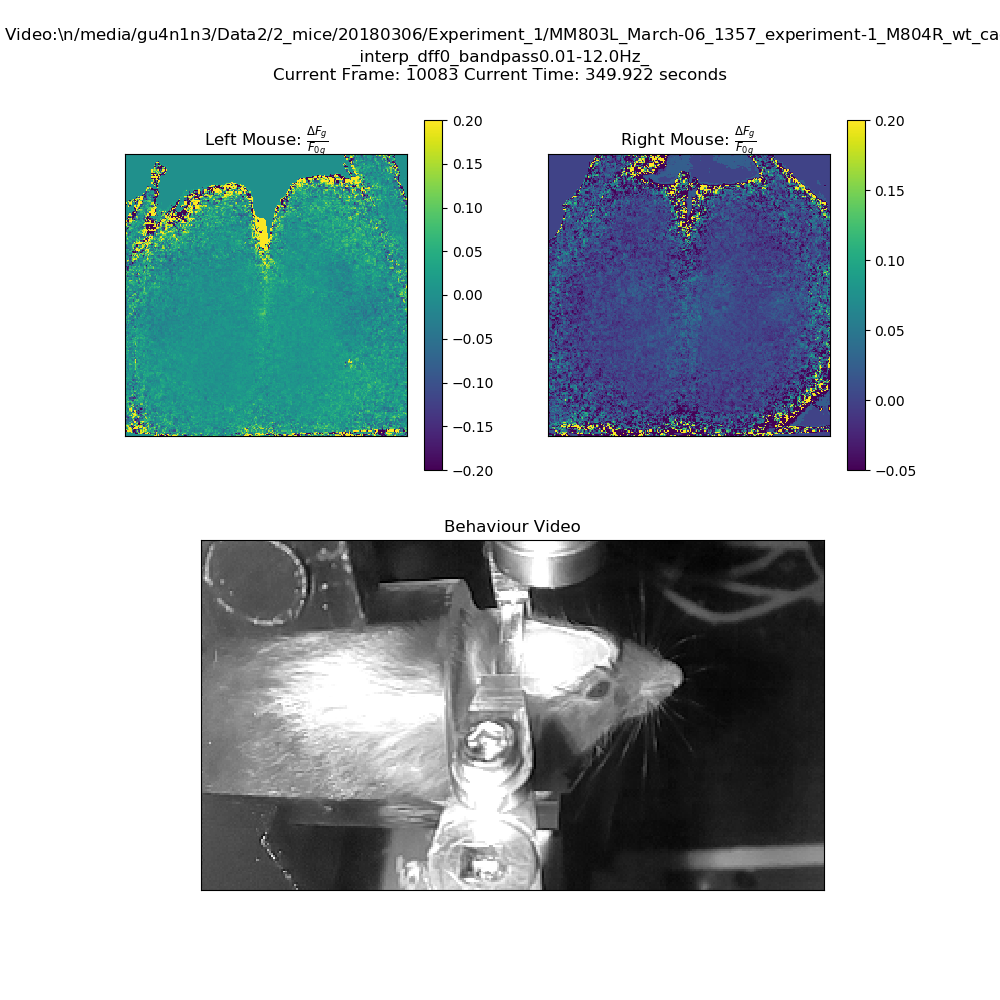

Writing frames...
Done!


In [33]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=directory+experiment, artist='Fed',
                comment='10Hz_playback')
writer = FFMpegWriter(fps=30, metadata=metadata, bitrate=6000)
fig = plt.figure(figsize=(10, 10))
fig.suptitle("The Signals for:\n"+left_mouse+"\n"+processing+"\n")

lax1 = fig.add_subplot(2, 2, 1)
#lax1.set_title(r"Left Mouse: $\frac{\Delta F_g/F_{0g}}{1+\Delta F_b/F_{0b}}$")
lax1.set_title(r"Left Mouse: $\frac{\Delta F_g}{F_{0g}}$")
lax1.get_yaxis().set_visible(False)
lax1.get_xaxis().set_visible(False)
lim_gb = lax1.imshow(corrected_left_mouse_green_by_blue_frames[0], cmap='viridis', vmin=-0.2, vmax=0.2)
cbar1 = fig.colorbar(lim_gb)

rax1 = fig.add_subplot(2, 2, 2)
#rax1.set_title(r"Right Mouse: $\frac{\Delta F_g/F_{0g}}{1+\Delta F_b/F_{0b}}$")
rax1.set_title(r"Right Mouse: $\frac{\Delta F_g}{F_{0g}}$")
rax1.get_yaxis().set_visible(False)
rax1.get_xaxis().set_visible(False)
rim_gb = rax1.imshow(corrected_right_mouse_green_by_blue_frames[0], cmap='viridis', vmin=-0.05, vmax=0.2)
cbar2 = fig.colorbar(rim_gb)

ax3 = fig.add_subplot(2, 1, 2)
ax3.set_title("Behaviour Video")
ax3.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
im_beh = ax3.imshow(subset_behaviour_frames[0], cmap='gray', vmin=0, vmax=255)









print("Writing frames...")
with writer.saving(fig, directory+experiment+left_mouse.split("/")[-1]+"_activity_and_behaviour_"+processing+".mp4", 100):
    for i in range(left_mouse_green_frames.shape[0]):
        # Set title
        current_time = np.round(float(i)/TRUE_FRAMERATE, 3)
        fig.suptitle(r"uncorrected $Ca^{2+}$ activity and Behaviour Video:\n"\
                     +left_mouse+"\n"+\
                     processing+"\n"+\
                     "Current Frame: "+"{:5d}".format(i)+" Current Time: "+"{:4.3f}".format(current_time)+" seconds")
        

        lim_gb.set_data(left_mouse_green_frames[i])
        
        rim_gb.set_data(right_mouse_green_frames[i])
        
        im_beh.set_data(subset_behaviour_frames[i])

        writer.grab_frame()

print("Done!")

# Load already processed experiments

# Stim Averaging

In [162]:
with open(stim_frames_file, 'r') as file:
    stim_frames = file.readlines()
    for i in range(len(stim_frames)):
        stim_frames[i] = stim_frames[i].replace("\n", "")
        stim_frames[i] = int(stim_frames[i])-left_start_frame
        
    stim_frames = np.asarray(stim_frames)
fixed_stims = False
print(stim_frames)

[  158   359   561   763   961  1162  1364  1566  1767  1969  2171  2373
  2574  2776  2978  3180  3381  3583  3785  3986  4188  4383  4585  4786
  4988  5190  5391  5593  5795  5997  6198  6400  6602  6803  7005  7207
  7409  7610  7812  8014  8216  8417  8619  8821  9022  9224  9426  9628
  9829 10031 10233 10432]


In [163]:
assert not fixed_stims
for i, stim_frame in enumerate(stim_frames):
    last_adjusted_stim = None
    for pair in right_pairs:
        if stim_frame > pair.location:
            stim_frames[i] += pair.number_of_dropped_frames
            last_adjusted_stim = stim_frame
                
# remove the stim_frames that would happen when the lights are off
stim_frames = stim_frames[np.where(stim_frames<left_mouse_green_frames.shape[0]-100)]
    
fixed_stims = True
            
            
print(stim_frames)

[ 158  359  561  763  965 1166 1368 1570 1771 1973 2175 2377 2578 2780 2982
 3184 3385 3587 3789 3990 4192 4393 4595 4796 4998 5200 5401 5603 5805 6007
 6208 6410 6612 6813 7015 7217 7419 7620 7822 8024 8226 8427 8629 8831 9032
 9234 9436 9638 9839]


In [164]:
assert fixed_stims
print(left_mouse_green_frames.shape)
all_stim_frames = np.zeros((stim_frames.shape[0], 200, 256, 256))
for i, stim_frame in enumerate(stim_frames[:-1]):
    all_stim_frames[i] = gaussian_filter(left_mouse_green_frames[stim_frame-100:stim_frame+100], 2)
    



(10083, 256, 256)


In [135]:
left_green_frame = np.load(directory+experiment+"LEFT_RAW_GREEN_FRAME.npy")


# Make mask for whisker stim

In [13]:
plt.figure()
plt.imshow(left_green_frame, cmap='gray', vmin=0, vmax=150)
plt.xticks([])
plt.yticks([])
LM_left_hem = roipoly(roicolor='b')

<IPython.core.display.Javascript object>

NameError: name 'left_green_frame' is not defined

<IPython.core.display.Javascript object>


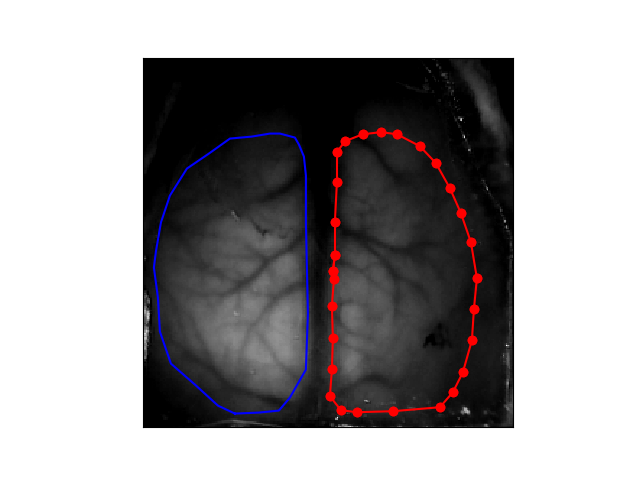

In [137]:
plt.figure()
plt.imshow(left_green_frame, cmap='gray', vmin=0, vmax=150)
LM_left_hem.displayROI()
plt.xticks([])
plt.yticks([])
LM_right_hem = roipoly(roicolor='r')

<IPython.core.display.Javascript object>


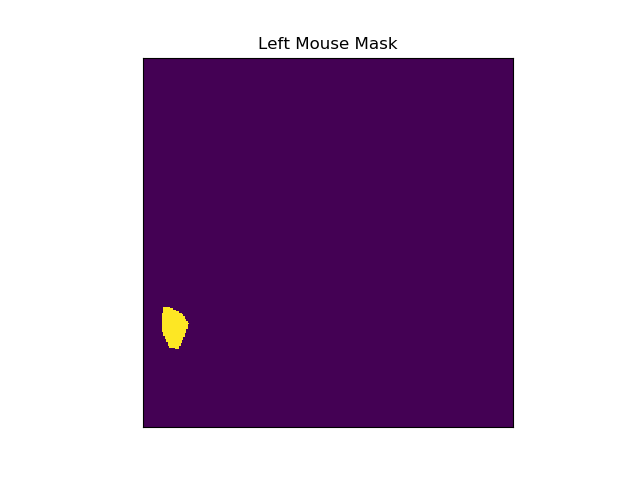

([], <a list of 0 Text yticklabel objects>)

In [165]:
plt.figure()

left_mouse_mask = np.logical_or(LM_left_hem.getMask(left_mouse_green_frames[2000]), LM_right_hem.getMask(left_mouse_green_frames[2000]))
plt.title("Left Mouse Mask")
plt.imshow(left_mouse_mask)
plt.xticks([])
plt.yticks([])


In [166]:
mean_stim_frames = np.mean(all_stim_frames, axis=0)
mean_stim_frames[:, ~left_mouse_mask] = -100

In [167]:
mean_stim_frames.tofile(directory+experiment+"mean_stim_frames.raw")
np.save(directory+experiment+"fixed_stim_frames.npy", stim_frames)

<IPython.core.display.Javascript object>


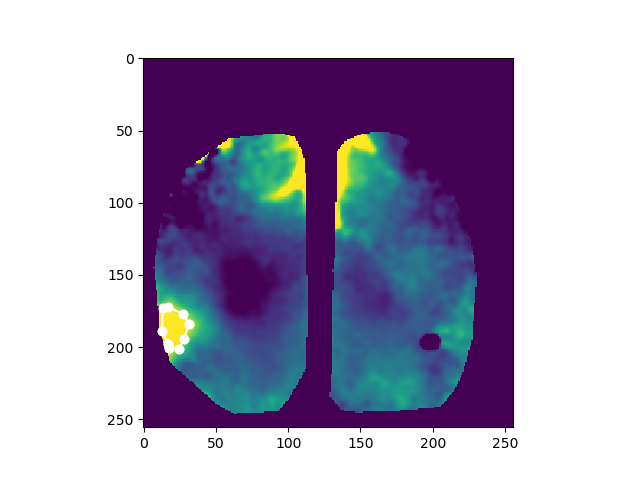

In [168]:
plt.figure()
plt.imshow(mean_stim_frames[125], vmin=0, vmax=0.02)
stim_roi = roipoly(roicolor='w')


In [ ]:
all_stim_frames.shape

In [169]:
stim_mask = stim_roi.getMask(mean_stim_frames[111])
plt.imshow(stim_mask)

<IPython.core.display.Javascript object>


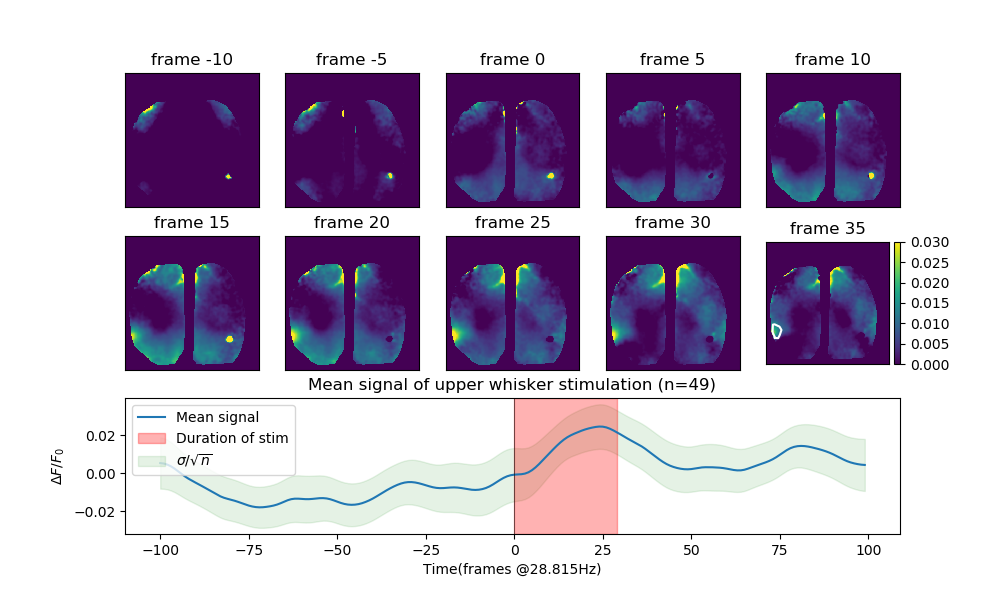

(49, 200, 256, 256)


In [172]:
plt.figure(figsize=(10, 6))
mean_stim_signal = np.mean(mean_stim_frames[:, stim_mask], axis=1)
all_stim_signals = np.mean(all_stim_frames[:, :, stim_mask], axis=2)
std_stim_signal = np.std(all_stim_signals, axis=0)/np.sqrt(all_stim_frames.shape[0])
print(np.shape(all_stim_frames))
time_stim = np.arange(-100, 100, 1)
montage_indeces = [90, 95, 100, 105, 110, 115, 120, 125, 130, 135]    
for i, index in enumerate(montage_indeces):
    plt.subplot(3, 5, i+1)
    plt.title("frame %s"%str(index-100))
    plt.imshow(mean_stim_frames[index], vmin=0, vmax=0.03)
    plt.yticks([])
    plt.xticks([])
stim_roi.displayROI()
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(313)
plt.title("Mean signal of upper whisker stimulation (n=%s)"%str(all_stim_signals.shape[0]))
plt.plot(time_stim, mean_stim_signal, label="Mean signal")
plt.fill_between(time_stim, mean_stim_signal-std_stim_signal, mean_stim_signal+std_stim_signal, alpha=0.1, color='g', label='$\sigma / \sqrt{n}$')
plt.ylabel(r"$\Delta F/F_0$")
plt.xlabel("Time(frames @28.815Hz)")
plt.axvline(0, color='k', linewidth=0.4)
plt.axvspan(0, 29, alpha=0.3, color='r', label="Duration of stim")

plt.legend()
plt.savefig(directory+experiment+"Whisker_stim_figure.png")


In [ ]:
#upper_whisker_peak = np.copy(mean_stim_frames[111])
plt.subplot(131)
plt.title("Lower stim")
plt.imshow(gaussian_filter(lower_whisker_peak,1), vmin=0, vmax=0.02)
plt.yticks([])
plt.xticks([])
plt.subplot(132)
plt.title("Upper stim")
plt.imshow(gaussian_filter(upper_whisker_peak, 1), vmin=0, vmax=0.02)
plt.yticks([])
plt.xticks([])
plt.subplot(133)
plt.title("Added stims")
plt.imshow(gaussian_filter(lower_whisker_peak+upper_whisker_peak, 1), vmin=0, vmax=0.02, cmap='viridis')
plt.yticks([])
plt.xticks([])

In [14]:
def corr(pixel, seed_pixel):
    return pearsonr(pixel, seed_pixel)[0]

def generate_matrix_two_mice(left_mouse_green_frames, right_mouse_green_frames, left_seeds, right_seeds, radius=5):
    all_seeds=np.zeros((np.size(left_seeds)+np.size(right_seeds),np.shape(left_mouse_green_frames)[0]))
    the_labels = []
    the_positions = []
    cnt=0
    # FIX ME REVERSED ROW AND COL
    left_first_frame[left_seeds[0].bregma.row, left_seeds[0].bregma.col] = 255
    for seed in left_seeds:
        the_labels.append(seed.name+"-L")
        top = seed.row-radius
        bottom = seed.row+radius
        left = seed.col-radius
        right = seed.col+radius
        
        if top < 0:
            top = 0
        if bottom > 256:
            bottom = 256
        if left < 0:
            left = 0
        if right > 256:
            right = 256
        seed.signal = np.mean(np.mean(left_mouse_green_frames[:, top:bottom, left:right], axis=1), axis=1)
        all_seeds[cnt,:]=seed.signal
        cnt+=1
        left_first_frame[top:bottom, left:right] = 255
        the_positions.append((seed.row, seed.col))
        
    #left_mouse_green_frames[0, :, :].tofile("left.raw")
    # FIX ME REVERESED ROW AND COL
    right_first_frame[right_seeds[0].bregma.row, right_seeds[0].bregma.col] = 255      
    for seed in right_seeds:
        
        the_labels.append(seed.name+"-R")
        top = seed.row-radius
        bottom = seed.row+radius
        left = seed.col-radius
        right = seed.col+radius
        
        if top < 0:
            top = 0
        if bottom > 256:
            bottom = 256
        if left < 0:
            left = 0
        if right > 256:
            right = 256
        seed.signal = np.mean(np.mean(right_mouse_green_frames[:, top:bottom, left:right], axis=1), axis=1)

        right_first_frame[top:bottom, left:right] = 255
        all_seeds[cnt,:]=seed.signal
        cnt+=1
        
        the_positions.append((seed.row, seed.col))

    
    
    
    #right_mouse_green_frames[0, :, :].tofile("right.raw")
    
    
    # Calculate correlation coefficients
    corr_mat=np.corrcoef(all_seeds)

    fig = plt.figure(figsize=(10,11))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr_mat, interpolation='nearest', vmin=0, vmax=1, cmap='viridis')
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    ax.set_title(title+"\n"+processing, y=1.15)
    ax.set_xticks([i for i in range(np.size(left_seeds)+np.size(right_seeds))])
    ax.set_yticks([i for i in range(np.size(left_seeds)+np.size(right_seeds))])
    ax.set_xticklabels(the_labels, rotation='vertical')
    ax.set_yticklabels(the_labels)
    print(the_labels)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.imshow(left_first_frame, cmap='gray')
    
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    ax3.imshow(right_first_frame, cmap='gray')
    print("Saving matrices at: "+directory+experiment)
    fig.savefig(directory+experiment+title+processing+".svg")
    np.save(directory+experiment+"the_signals.npy", all_seeds)
    np.save(directory+experiment+title+processing+".npy", corr_mat)
    np.save(directory+experiment+"the_seed_labels.npy", the_labels)
    np.save(directory+experiment+"the_positions.npy", the_positions)
    plt.show()


In [12]:
# Load processed files:
left_mouse_frames = get_processed_frames(directory+experiment+"left_mouse_gsr_frames.raw", 64, 64)
right_mouse_frames = get_processed_frames(directory+experiment+"right_mouse_gsr_frames.raw", 64, 64)

(10084, 64, 64)
(10084, 64, 64)


<IPython.core.display.Javascript object>


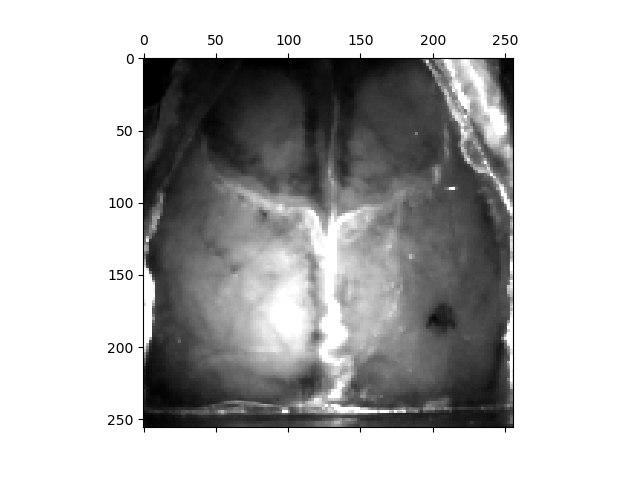

In [173]:
#Left Bregma selection
fig, ax = plt.subplots()
ax.matshow(orig_left_first_blue_frame, cmap='gray')
#ax.matshow(left_mouse_frames[100], cmap='viridis', vmin=0, vmax=0.2)
left_collector = []
def onclick(event):
    left_collector.append(Position(int(event.ydata), int(event.xdata)))
    
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


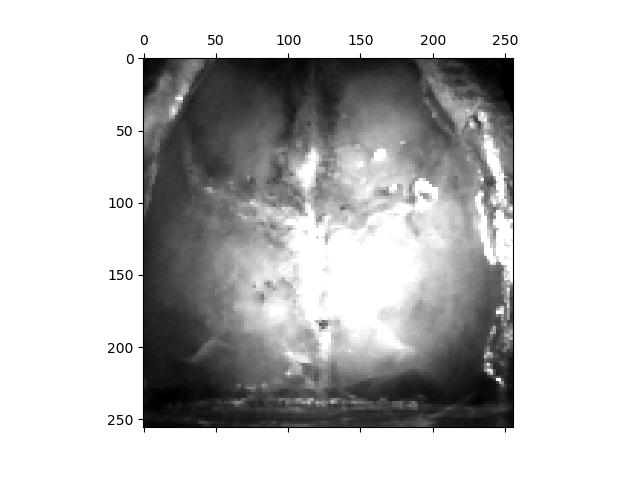

In [174]:
#Right Bregma selection
fig, ax = plt.subplots()
ax.matshow(orig_right_first_blue_frame, cmap='gray')
#ax.matshow(right_mouse_frames[100], cmap='viridis', vmin=0, vmax=0.2)

right_collector = []
def onclick(event):
    right_collector.append(Position(int(event.ydata), int(event.xdata)))
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [175]:
left_bregma = left_collector[-1]
right_bregma = right_collector[-1]
print(left_bregma.col, left_bregma.row)
print(right_bregma.col, right_bregma.row)

129 110
120 102


(22,)
(22,)


<IPython.core.display.Javascript object>


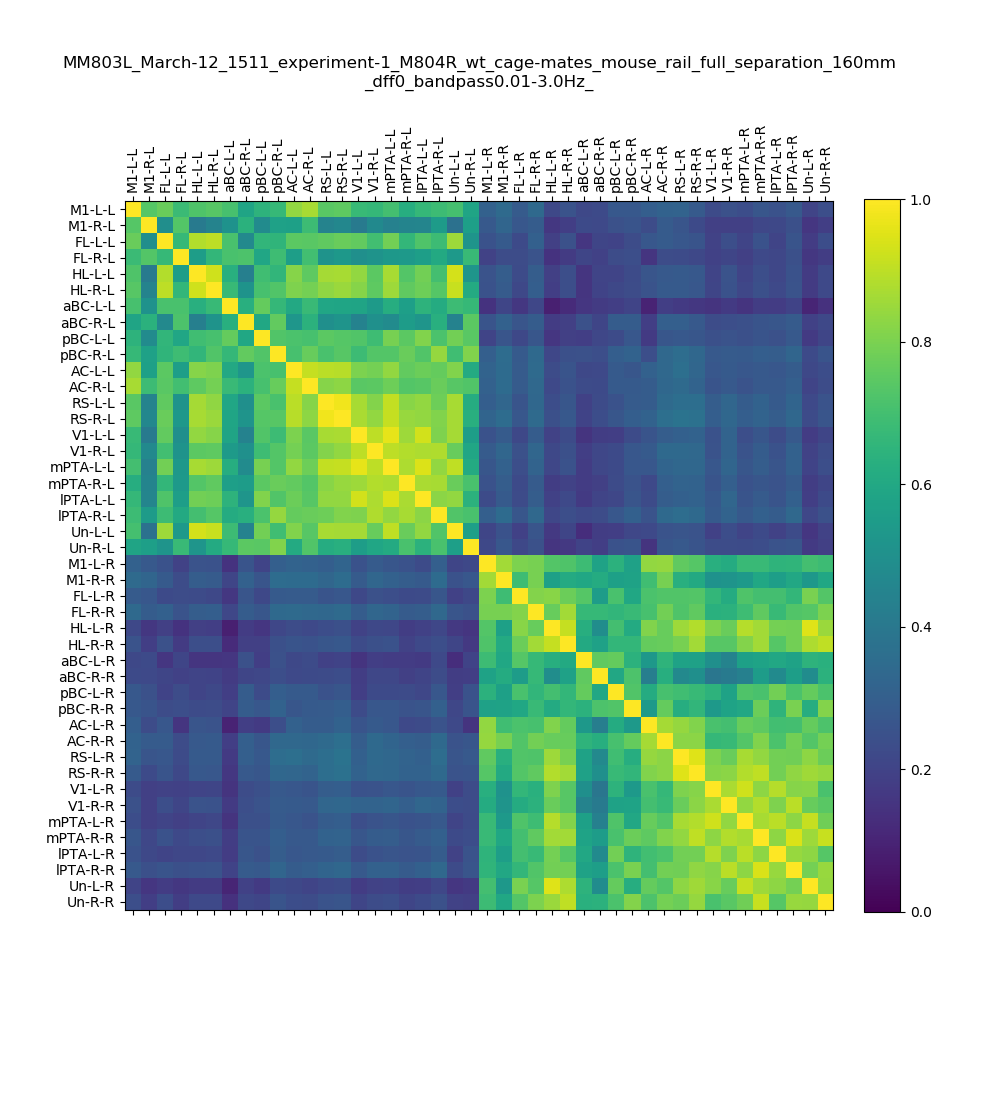

['M1-L-L', 'M1-R-L', 'FL-L-L', 'FL-R-L', 'HL-L-L', 'HL-R-L', 'aBC-L-L', 'aBC-R-L', 'pBC-L-L', 'pBC-R-L', 'AC-L-L', 'AC-R-L', 'RS-L-L', 'RS-R-L', 'V1-L-L', 'V1-R-L', 'mPTA-L-L', 'mPTA-R-L', 'lPTA-L-L', 'lPTA-R-L', 'Un-L-L', 'Un-R-L', 'M1-L-R', 'M1-R-R', 'FL-L-R', 'FL-R-R', 'HL-L-R', 'HL-R-R', 'aBC-L-R', 'aBC-R-R', 'pBC-L-R', 'pBC-R-R', 'AC-L-R', 'AC-R-R', 'RS-L-R', 'RS-R-R', 'V1-L-R', 'V1-R-R', 'mPTA-L-R', 'mPTA-R-R', 'lPTA-L-R', 'lPTA-R-R', 'Un-L-R', 'Un-R-R']


<IPython.core.display.Javascript object>


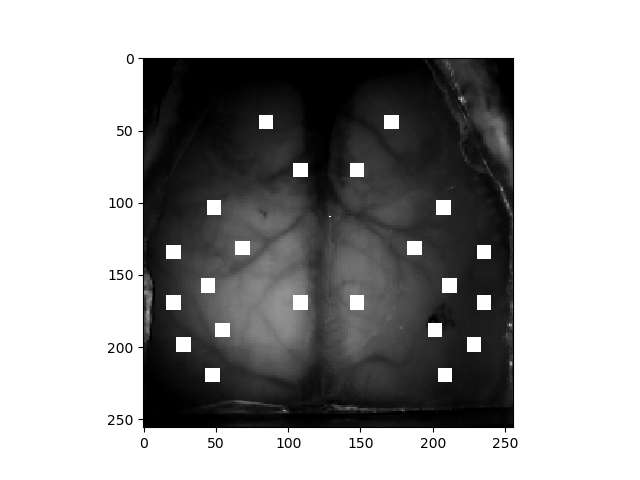

<IPython.core.display.Javascript object>


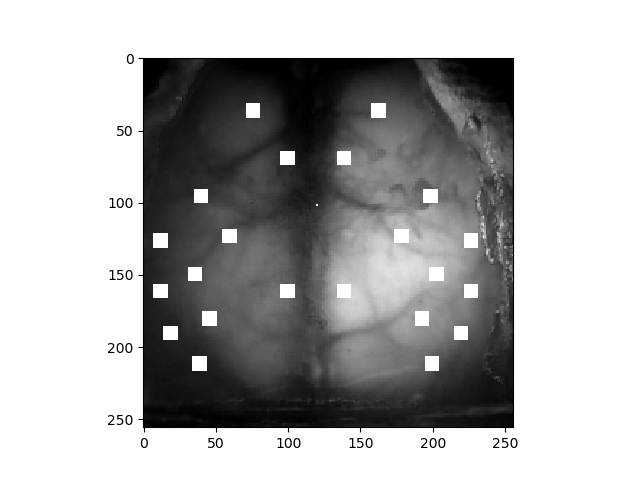

Saving matrices at: /media/gu4n1n3/Data2/2_mice/20180312/Experiment_1/


In [176]:
# From imagej first number is y and second number is x
# left_bregma = Position(110,125)
# right_bregma = Position(152,130)

# left_ppmm = 26
# right_ppmm = 25.5

#left_bregma = Position(97,128)
#right_bregma = Position(152,130)
#right_bregma = Position(147,139)

left_ppmm = 32
right_ppmm = 32

# left_bregma = Position(93,132)
# right_bregma = Position(158,133)

# left_ppmm = 26.5
# right_ppmm = 22.88


left_first_frame = np.copy(orig_left_first_green_frame)
right_first_frame = np.copy(orig_right_first_green_frame)


#Generate seeds
# generate_seeds(bregma, ppmm, direction=None):
left_seeds = generate_seeds(left_bregma, left_ppmm, direction='u')
right_seeds = generate_seeds(right_bregma, right_ppmm, direction='u')
print(np.shape(left_seeds))
print(np.shape(right_seeds))
matrix = generate_matrix_two_mice(left_mouse_green_frames, right_mouse_green_frames, left_seeds, right_seeds)

In [ ]:
print(processing)
processing="_dff0_bandpass0.1-12Hz_gsr_"

In [ ]:
width = 128
height = 128

# Interpolate video frames and save them as an 8bit file.
video_file = "/media/gu4n1n3/Data/2_mice/20170811/M1_August-12_0013_experiment-2_GluSnfR_50ms_pulses_every_10s_paw_stim_60fps.raw"
timestamps_filename = "/media/gu4n1n3/Data/2_mice/20170811/M1_August-12_0013_experiment-2_GluSnfR_50ms_pulses_every_10s_paw_stim_60fps_timestamps.raw"
mask_filename = "/media/gu4n1n3/Data/2_mice/20170804/mask.raw"

green_frames = get_raw_frames(video_file, 1)
raw_timestamps = open_raw_timestamps(timestamps_filename)

differences, frame_drop_timepoints = get_locations_of_dropped_frames(raw_timestamps)
print(frame_drop_timepoints)
pairs = generate_pairs(green_frames, frame_drop_timepoints, differences)
# Improve i guess? since pairs is passed by reference, we don't have to return anything.
# but it looks ugly :/
pairs_to_interp(pairs)

green_frames = insert_interpolated_frames_to_video(green_frames, pairs)

print("Removing dark frames!")
start, stop = get_dark_frames(green_frames)
green_frames = green_frames[start+2:stop-1, :, :]

var_green_frames = np.var(green_frames, axis=0)


green_frames = calculate_df_f0(green_frames)
green_frames = highpass_filter(green_frames, 0.1, TRUE_FRAMERATE)

print('done')

In [ ]:
class ProcessedFrames():
    def __init__(self, green_frames, blue_frames, og, ob, var, mean, title, processing_log):
        self.green_frames = green_frames
        self.blue_frames = blue_frames
        self.og = og
        self.ob = ob
        self.var = var
        self.mean = mean
        self.title = title
        self.processing_log = processing_log

def process_imaging_data(imaging_file, timestamps_file, frame_rate, width, height):
    processing = "_"

    print("Importing video files...",imaging_file)
    green_frames = get_raw_frames(imaging_file, 1)
    blue_frames = get_raw_frames(imaging_file, 2)
    title = imaging_file.split('/')[-1]
    title = title.split('.')[0]
    print("[DONE]")

    print("Importing timestamps...",)
    timestamps = open_raw_timestamps(timestamps_file)
    print("[DONE]")

    print("Calculating differences and the framedrop timepoints...",)
    differences, frame_drop_timepoints = get_locations_of_dropped_frames(timestamps)
    print("[DONE]")


    print("Generating pairs of frames where between the two are the missing frames...",)
    green_pairs = generate_pairs(green_frames, frame_drop_timepoints, differences)
    blue_pairs = generate_pairs(blue_frames, frame_drop_timepoints, differences)
    print("[DONE]")

    print("Interpolating the data...",)
    if len(green_pairs) > 0:
        processing += "interp_"
    pairs_to_interp(green_pairs)
    pairs_to_interp(blue_pairs)
    print("[DONE]")

    print("Inserting new frames into the raw data...",)
    green_frames = insert_interpolated_frames_to_video(green_frames, green_pairs)
    blue_frames = insert_interpolated_frames_to_video(blue_frames, blue_pairs)
    print("[DONE]")

    print("Removing dark frames!")
    # lag = -8
    # processing += "%s_FramesLag_" % (str(lag)
    print(np.shape(green_frames))
    start, stop = get_dark_frames(green_frames)
    green_frames = green_frames[start+2:stop-1, :, :]
    start, stop = get_dark_frames(blue_frames)
    blue_frames = blue_frames[start+2:stop-1, :, :]

    print(green_frames.shape)

    orig_first_green_frame = np.copy(green_frames[0, :, :])
    #orig_first_blue_frame = np.copy(blue_frames[0, :, :])

    var_green_frames = np.var(green_frames, axis=0)
    mean_green_frames = np.mean(green_frames, axis=0)


    processing += "dff0_"
    green_frames = calculate_df_f0(green_frames)
    #blue_frames = calculate_df_f0(blue_frames)


    processing += "bandpass0.1-12Hz_"
    green_frames = cheby_filter(green_frames, 0.01, 3.0, frame_rate)
    #blue_frames = cheby_filter(blue_frames, 0.1, 12, frame_rate)
    
    
    return ProcessedFrames(green_frames, None, orig_first_green_frame, 
                           None, var_green_frames, mean_green_frames, title, processing)
    
    
    

In [ ]:
# Alone Mice Experiments:
directory = "/media/gu4n1n3/Data/2_mice/20170920/"
experiment = "Experiment_4/"

import os
from os.path import join, getsize
imaging_file = ''
timestamps_file = ''
for root, dirs, files in os.walk(directory+experiment):
    if not "Behaviour" in root:
        for file in files:
            if ".raw" in file:
                if "timestamps" in file:
                    timestamps_file = os.path.join(directory, experiment, file)
                else:
                    imaging_file = os.path.join(directory, experiment, file)
print(imaging_file)
print(timestamps_file)
assert("alone" in imaging_file)
assert("alone" in timestamps_file)


In [ ]:
alone_proc_frames = process_imaging_data(imaging_file, timestamps_file, TRUE_FRAMERATE, width, height)

In [ ]:
def generate_matrix_one_mouse(proc_frames, seeds, radius=5):
    all_seeds=np.zeros((np.size(seeds), np.shape(proc_frames.green_frames)[0]))
    the_labels = []
    the_positions = []
    cnt=0
    # FIX ME REVERSED ROW AND COL
    first_frame = np.copy(proc_frames.og)
    first_frame[seeds[0].bregma.row, seeds[0].bregma.col] = 255
    for seed in seeds:
        the_labels.append(seed.name)
        top = seed.row-radius
        bottom = seed.row+radius
        left = seed.col-radius
        right = seed.col+radius
        
        if top < 0:
            top = 0
        if bottom > 256:
            bottom = 256
        if left < 0:
            left = 0
        if right > 256:
            right = 256
        seed.signal = np.mean(np.mean(proc_frames.green_frames[:, top:bottom, left:right], axis=1), axis=1)
        all_seeds[cnt,:]=seed.signal
        cnt+=1
        
        first_frame[top:bottom, left:right] = 255
        
        the_positions.append((seed.row, seed.col))
        

    
    # Calculate correlation coefficients
    corr_mat=np.corrcoef(all_seeds)

    fig = plt.figure(figsize=(7, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr_mat, interpolation='nearest', vmin=0, vmax=1, cmap='viridis')
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    ax.set_title(proc_frames.title+"\n"+proc_frames.processing_log, y=1.15)
    ax.set_xticks([i for i in range(np.size(seeds))])
    ax.set_yticks([i for i in range(np.size(seeds))])
    ax.set_xticklabels(the_labels, rotation='vertical')
    ax.set_yticklabels(the_labels)
    print(the_labels)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.imshow(first_frame, cmap='gray')
    
    
    print("Saving matrices at: "+directory+experiment)
    fig.savefig(directory+experiment+proc_frames.title+proc_frames.processing_log+".svg")
    np.save(directory+experiment+"the_signals.npy", all_seeds)
    np.save(directory+experiment+proc_frames.title+proc_frames.processing_log+".npy", corr_mat)
    np.save(directory+experiment+"the_seed_labels.npy", the_labels)
    np.save(directory+experiment+"the_positions.npy", the_positions)
    plt.show()


In [ ]:
#Bregma selection
fig, ax = plt.subplots()
ax.matshow(alone_proc_frames.og, cmap='gray')
collector = []
def onclick(event):
    print(event.xdata, event.ydata)
    collector.append(Position(int(event.ydata), int(event.xdata)))
    
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
bregma = collector[-1]
print(bregma.col, bregma.row)



ppmm = 24


#Generate seeds
# generate_seeds(bregma, ppmm, direction=None):
seeds = generate_seeds(bregma, ppmm, direction='u')
print(np.shape(seeds))
matrix = generate_matrix_one_mouse(alone_proc_frames, seeds)

In [ ]:
#PERSONALIZED MASKS CAUSE ASS LIGHTING
with open("/media/gu4n1n3/Data/2_mice/20170811/mask_glu.raw", "rb") as file:
    mask_glu = np.fromfile(file, dtype=np.uint8)
    mask_glu = np.reshape(mask_glu, (width, height))
    
plt.figure()
plt.imshow(mask_glu)
plt.show()

In [ ]:
gsr_glu_frames, mean_g = masked_gsr(green_frames, mask_glu)

plt.figure()
plt.plot(mean_g)
plt.show()

In [ ]:
with open("/media/gu4n1n3/Data/2_mice/20170811/M1_August-12_0013_experiment-2_GluSnfR_50ms_pulses_every_10s_paw_stim_60fps.txt",'r') as file:
    data = file.readlines()
    for i, line in enumerate(data):
        data[i] = float(line.replace('\n', ''))
        data[i] = int(data[i]/16636.5)
        
    data = data[1:]
    
    print(data)
    data = np.asarray(data)

In [ ]:
stim_frames = np.zeros((len(data), 300, 128, 128))
for i, n_stim_frame in enumerate(data):
    stim_frames[i, :, :, :] = gsr_glu_frames[n_stim_frame-150:n_stim_frame+150, :, :]

In [ ]:
stim_frames = np.mean(stim_frames, axis=0)
stim_frames.tofile("/media/gu4n1n3/Data/2_mice/20170811/stim_frames_dff0_0.1Hz-highpass_gsr.raw")

In [ ]:
trace = stim_frames[:, 59:79, 24:45]
trace = np.mean(np.mean(trace, axis=1), axis=1)
x = np.arange(-150, 150, 1)
plt.figure()
plt.title("Trace for FL area, frame 0 is stim frame.")
plt.ylabel("Proportion dF/F0")
plt.xlabel("Frames (60fps)")
plt.plot(x, trace)
plt.show()

In [ ]:
# type is one of 'all', 'cortex', 'ob'
def get_hemisphere_mask(hemisphere, type='all', dir='l'):
    img = cv2.GaussianBlur(hemisphere,(13, 13),0)
    #img = hemisphere
    ret, thresh = cv2.threshold(img, 150, 220, 0)
    th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    hulls = []
    # Brain hemisphere contour is the largest.
    largest_contour = contours[0]
    for i, contour in enumerate(contours):
        if np.shape(contour)[0] > np.shape(largest_contour)[0]:
            largest_contour = contour
    # Append the cortical hemisphere (largest_contour)
    hulls.append(cv2.convexHull(largest_contour, False))    
    
    if type == 'cortex':
        return hulls
    elif type == 'ob':
        hulls = []

    
#     min_row = np.min(largest_contour, axis=0)[0][1]
#     max_row = np.max(largest_contour, axis=0)[0][1]
#     print(min_row)
#     print(max_row)
#     for i, contour in enumerate(contours):
#         if np.shape(contour)[0] > 30 and np.shape(contour)[0] <150 and cv2.contourArea(contour) > 500:
#             #hull = cv2.convexHull(contour, False)
#             #hulls.append(hull)
#             if dir == 'r':
#                 if np.min(contour, axis=0)[0][1] >= max_row+15:
#                     hull = cv2.convexHull(contour, False)
#                     hulls.append(hull)
#             elif dir == 'l':
#                 if np.max(contour, axis=0)[0][1] <= min_row-15:
#                     hull = cv2.convexHull(contour, False)
#                     hulls.append(hull)
            
    return hulls

In [ ]:
import cv2
#import seaborn as sns
#sns.set()
#Plan. based on bregma generate mask with which you will multiply the values inside by.
# Then use that to find the boundaries? May work better
left_copy_var = np.copy(left_mean_green_frames)*(left_var_green_frames)
left_percentile = np.percentile(left_var_green_frames, 95)
left_copy_var /= left_percentile
print(np.max(left_copy_var))
#print(np.max(left_copy_var))
#left_copy_var /= left_mean
left_copy_var[np.where(left_copy_var>255)] = 255
left_copy_var = left_copy_var.astype(np.uint8)
left_mask = np.copy(left_copy_var)

right_copy_var = np.copy(right_mean_green_frames)*np.sqrt(right_var_green_frames)
right_copy_var[np.where(right_copy_var>255)] = 255
right_copy_var = right_copy_var.astype(np.uint8)
right_mask = np.copy(right_copy_var)



#Above Bregma
left_copy_var_up = np.copy(left_copy_var)
left_copy_var_up[:, left_bregma.col:] = 0
# Below Bregma
left_copy_var_down = np.copy(left_copy_var)
left_copy_var_down[:, :left_bregma.col] = 0

#Above Bregma
right_copy_var_up = np.copy(right_copy_var)
right_copy_var_up[:, right_bregma.col:] = 0
# Below Bregma
right_copy_var_down = np.copy(right_copy_var)
right_copy_var_down[:, :right_bregma.col] = 0


#PERSONALIZED MASKS CAUSE ASS LIGHTING
# with open("/media/gu4n1n3/Data/2_mice/20170802/Experiment_16/left_mask_185.raw", "rb") as file:
#     mask_185 = np.fromfile(file, dtype=np.uint8)
#     mask_185 = np.reshape(mask_185, (width, height))
# left_mask = mask_185

#Empty Images:
left_mask = np.zeros_like(left_copy_var)
right_mask = np.zeros_like(right_copy_var)
# #Above Bregma
#left_up_hull = get_hemisphere_mask(left_copy_var_up, 'all', 'l')
#cv2.drawContours(left_mask, left_up_hull, -1, (255), -1)

#Below Bregma
#left_down_hull = get_hemisphere_mask(left_copy_var_down, 'all', 'l')
#cv2.drawContours(left_mask, left_down_hull, -1, (255), -1)

#Above Bregma
#right_up_hull = get_hemisphere_mask(right_copy_var_up, 'all', 'r')
#cv2.drawContours(right_mask, right_up_hull, -1, (255), -1)
#Below Bregma
#right_down_hull = get_hemisphere_mask(right_copy_var_down, 'all', 'r')
#cv2.drawContours(right_mask, right_down_hull, -1, (255), -1)

#sns.set_style("white")
plt.figure()
plt.subplot(221)
plt.imshow(left_mask,cmap='gray')
plt.subplot(222)
plt.imshow(right_mask, cmap='gray')
plt.subplot(223)
plt.imshow(left_var_green_frames, cmap='gray')
plt.subplot(224)
plt.imshow(left_mean_green_frames, cmap='gray')
plt.show()



# gsr_frames.tofile("testing.raw")


In [ ]:
processing+= "gsr_"
left_gsr_frames, left_mean_g = gsr(left_mouse_green_frames, left_mask)
right_gsr_frames, right_mean_g = gsr(right_mouse_green_frames, right_mask)

In [ ]:
# Save GSR combined:
#Save em.
print("Saving!")
combined = np.concatenate((left_gsr_frames, right_gsr_frames), axis=2)
combined = combined.astype(np.float32)
combined.tofile(directory+experiment+"combined"+processing+".raw")
print("done")

In [ ]:
gsr_corr = pearsonr(left_mean_g, right_mean_g)[0]
plt.figure(figsize=(12,7))
plt.title("Global signal across mousies.\n"+title+"\nCorrelation between signals: "+str(gsr_corr))
plt.ylabel("Proportion dF/F0")
plt.xlabel("Frames (30fps)")
plt.plot(left_mean_g, 'b', label='Left Mouse')
plt.plot(right_mean_g, 'r', label='Right Mouse')
plt.legend()
plt.savefig(directory+experiment+processing+"global_signal.svg")
plt.show()

In [ ]:
plt.figure()
plt.title("Global signal of different areas.\n"+title)
plt.ylabel("Proportion dF/F0")
plt.xlabel("Frames (30fps)")
plt.plot(ob_cortex_signal, label='ob+cortex')
plt.plot(cortex_signal, label='cortex')
plt.plot(ob_signal, label='ob')
plt.legend()

In [ ]:
def plot_seed_pixel_gallery(shape, seeds, seed_frames, other_frames, rotation, skip, suptitle, figname):
    # Generate library of seed pixel correlation maps left mouse
    corr_maps = np.zeros((len(seeds), width, height))
    
    f = plt.figure(figsize=(13, 13))
    f.suptitle(suptitle)
    counter = 0
    
    #Create empty plots at the beginning.
    for i in range(1, skip+1):
        ax = f.add_subplot(5, 5, i)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    #Generate the actual plots.
    for s, seed in enumerate(seeds):
        seed_signal =  seed_frames[:, seed.row, seed.col]
        for i in range(other_frames.shape[1]):
            for j in range(other_frames.shape[2]):

                corr_maps[s, i, j] = pearsonr(other_frames[:, i, j], seed_signal)[0]

        print(seed.name)
        # Rotate the image 1 is 90 CCW
        # -1 is 90 CW
        #corr_maps[s] = np.rot90(corr_maps[s], rotation)
        ax = f.add_subplot(shape, shape, s+1+skip)
        t = ax.matshow(corr_maps[s], vmin=0, vmax=0.7, cmap='viridis')
        ax.set_title(seed.name)
        f.colorbar(t, ax=ax, fraction=0.046, pad=0.04)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    plt.savefig(directory+experiment+"seed_gallery_"+figname+processing+".svg")
    plt.show()

In [ ]:
#Make the masks
left_mask[np.where(left_mask != 255)] = 0
left_mask[np.where(left_mask == 255)] = 1
right_mask[np.where(right_mask != 255)] = 0
right_mask[np.where(right_mask == 255)] = 1


In [ ]:
# mask out areas of the brain!
masked_left_mouse_green_frames = left_mouse_green_frames*left_mask
masked_right_mouse_green_frames = right_mouse_green_frames*right_mask


In [ ]:
# The gallery for the left mouse
plot_seed_pixel_gallery(5, left_seeds, left_gsr_frames, left_gsr_frames, 1, 1, "LEFT " + title, "LeftOnLeft_")

In [ ]:
# The gallery for the right mouse




plot_seed_pixel_gallery(5, right_seeds, right_gsr_frames, right_gsr_frames, -1, 1, "RIGHT " + title, "RightOnRight_")

In [ ]:
# The seeds of the right mouse correlated on the left mouse.
plot_seed_pixel_gallery(5, right_seeds, right_mouse_green_frames, left_mouse_green_frames, 1, 1, "Right seed on left mouse " + title, "RightOnLeft_")

In [ ]:
# The seeds of the right mouse correlated on the left mouse.
plot_seed_pixel_gallery(5, left_seeds, left_gsr_frames, right_gsr_frames, -1, 1, "Left seeds on right mouse " + title, "LeftOnRight_")